In [1]:

import numpy as np # linear algebra

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
seed = 2022
np.random.seed(seed)

**Load Cifar10 data**

In [5]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = (train_data/255.).astype("float32")
test_data = (test_data/255.).astype("float32")

170508288/170498071 [==============================] - 3s 0us/step


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

**Makes data augmentation generator**

In [7]:
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

**Defines ViT model**

In [8]:


# 数据处理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 数据处理
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 转换数据为PyTorch的TensorDataset
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

# 转换数据为PyTorch的DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 构建模型
class VisionTransformer(nn.Module):
    def __init__(self, image_size, num_classes):
        super(VisionTransformer, self).__init__()
        self.image_size = image_size
        self.base_model = models.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True, include_top=False, pretrained_top=False)
        self.base_model.eval()

        self.fc1 = nn.Linear(self.base_model.embed_dim, 32)
        self.batch_norm1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.interpolate(x, size=(self.image_size, self.image_size), mode='bilinear', align_corners=False)
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.batch_norm1(x)
        x = self.fc2(x)
        return x

model = VisionTransformer(image_size=256, num_classes=10)


**Step1: Train only top layer (Transfer learning step)**

In [9]:
# 模型训练
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {train_loss:.4f}, '
              f'Training Accuracy: {100 * train_accuracy:.2f}%')

# 模型训练
train_model(model, train_loader, criterion, optimizer, num_epochs=2)

347512832/347502902 [==============================] - 2s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  UserWarning,


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vit-b16 (Functional)         (None, 768)               85844736  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 32)                24608     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

812

**Step2: Train entire layers again (Fine tuning step)**

In [10]:
def train_model(model, train_loader, criterion, optimizer, scheduler, early_stopping, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {train_loss:.4f}, '
              f'Training Accuracy: {100 * train_accuracy:.2f}%')

        scheduler.step(train_loss)
        early_stopping(train_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

# 模型训练
train_model(model, train_loader, criterion, optimizer, scheduler, early_stopping, num_epochs=10)

# 模型评估
model.eval()
test_predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        test_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(true_labels, test_predictions)
print("\nTest Accuracy: ", 100 * test_accuracy)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vit-b16 (Functional)         (None, 768)               85844736  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 32)                24608     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

**Plot learning history**

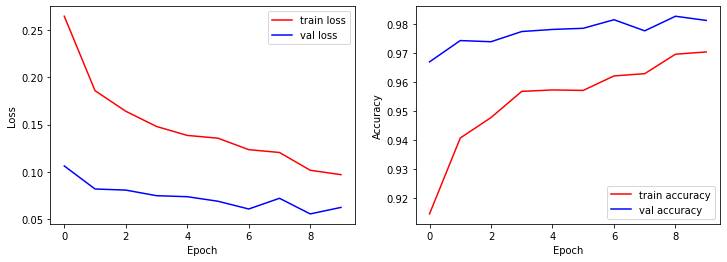

In [11]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()